In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import sys
sys.path.append("../../../")

import numpy as np

%matplotlib widget

In [2]:
from qiskit import transpile
from qiskit import QuantumCircuit
from qiskit.circuit.random import random_circuit
from weyl_decompose import RootiSwapWeylDecomposition as decomposer
from qiskit.transpiler.passes import Collect2qBlocks, ConsolidateBlocks, Unroll3qOrMore, Optimize1qGates
from src.utils.custom_gates import RiSwapGate
from qiskit.circuit.library import CXGate
from qiskit.converters import circuit_to_dag
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.quantum_info import Operator
from src.basis import MixedOrderBasisCircuitTemplate
from src.utils.polytope_wrap import monodromy_range_from_target
from src.scripts.gate_exploration.bgatev2script import get_group_name, cost_scaling, pick_winner
from qiskit.transpiler.basepasses import AnalysisPass
from qiskit.transpiler.passes import CountOps
from qiskit.dagcircuit import DAGOpNode, DAGCircuit
from qiskit.transpiler import PassManager

In [3]:
# main TODO summary:
# passes arent doing any swap things yet
# not finding a basis gate between each qubit pair after swap pass

In [4]:
from qiskit.circuit.library import QuantumVolume
qc = QuantumVolume(64, depth=128).decompose()
duration_1q = .25

In [5]:
# looking for some way to more directly use transpiler optimization level 3
# can use the same pass manager configuration for layout and routing?
# then change to custom once we get to the gate translation

In [6]:
class fooAnalysis(AnalysisPass):
    """print duration of the circuit (iswap = 1 unit)"""
    def run(self, dag):
        d = 0 #tracking critical path duration
        for gate in dag.longest_path():
            if isinstance(gate, DAGOpNode):
                d += gate.op.duration if gate.op.duration is not None else 0
                if gate.op.name in ['u', 'u1', 'u2', 'u3']:
                    d += duration_1q
                if gate.op.name in ['cx']:
                    d += 1
        self.property_set['duration'] = d

In [7]:
class pass_manager_basic(PassManager):
    def __init__(self, gate='iswap'):
        passes = []
        # collect 2Q blocks
        passes.extend([Unroll3qOrMore(), Collect2qBlocks(), ConsolidateBlocks(force_consolidate=True)])
        if gate == 'iswap':
            passes.extend([decomposer(basis_gate=RiSwapGate(1/2))])
        elif gate == 'cx':
            passes.extend([decomposer(basis_gate=CXGate())])
        #combine 1Q gates
        passes.extend([Optimize1qGates()])
        passes.extend([CountOps(), fooAnalysis()])
        super().__init__(passes)

INFO:qiskit.transpiler.runningpassmanager:Pass: Unroll3qOrMore - 1.54018 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Collect2qBlocks - 14.69684 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: ConsolidateBlocks - 2324.59688 (ms)
INFO:root:[0.         0.         0.03926991 0.74612826 1.        ]
INFO:root:[ 1.85240371  1.75        3.25       -0.5        -0.5       ]
INFO:root:0.5
INFO:root:Done build coverage set
INFO:qiskit.transpiler.runningpassmanager:Pass: SpeedGateSubstitute - 133180.91798 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 3783.79583 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CountOps - 0.04649 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: fooAnalysis - 9.91035 (ms)


Transpilation Results:
{'2QGate': 8627, 'u3': 17318}
243.25


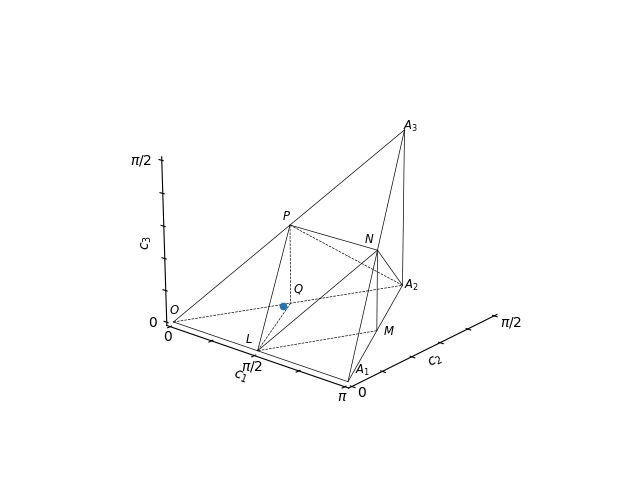

In [8]:
#TODO in the transpiler method, change metric to be sampled from algorithm's distribution
# in particular, want to sample from the set of gates being applied between each pair of qubits
# so that we can assign best gate to each pair of qubits

#this pass needs to know more about what qubits are being used
class SpeedGateSubstitute(TransformationPass):
    def __init__(self, speed_method='linear', duration_1q=0):
        super().__init__()
        self.speed_method = speed_method
        self.duration_1q = duration_1q
        cost_scaling(speed_method=speed_method, duration_1q=duration_1q) #just makes sure the data exists first
        self.group_name = get_group_name(speed_method, duration_1q)
    
    def run(self, dag: DAGCircuit):
        """Run the pass on `dag`."""
        #for starters, we are going to use a generic metric that wille be the same for all pairs of qubits
        w = pick_winner(self.group_name, metric=0) #TODO redefine the metric
        #that way we only have to compute a single coverage set
        template = MixedOrderBasisCircuitTemplate(base_gates=[w], chatty_build=0, bare_cost=False)
        logging.info("Done build coverage set")

        for node in dag.two_qubit_ops():
            target = Operator(node.op).data

            #TODO building the coverage sets takes a long time -- is there a way to cache them?
            reps = monodromy_range_from_target(template, target_u =target)[0] 
            
            template.build(reps)
            #we should set all the U3 gates to be real valued - doesn't matter for sake of counting duration
            sub_qc = template.assign_Xk(template.parameter_guess())
            sub_dag = circuit_to_dag(sub_qc)
            dag.substitute_node_with_dag(node, sub_dag)
        return dag 

# turn speed limited into a pass
pm = PassManager()
# collect 2Q blocks
pm.append([Unroll3qOrMore(), Collect2qBlocks(), ConsolidateBlocks(force_consolidate=True)])

method = 'linear' #linear or dynamic
pm.append(SpeedGateSubstitute(speed_method=method, duration_1q=duration_1q))
#combine 1Q gates
pm.append([Optimize1qGates()])
pm.append([CountOps(), fooAnalysis()])

transp2 = pm.run(qc)
print("Transpilation Results:")
print(pm.property_set['count_ops'])
print(pm.property_set['duration'])

In [9]:
#transp1 = transpile(qc, optimization_level=3, basis_gates=['u', 'id', 'cx'])
pm = pass_manager_basic(gate='iswap')
transp1 = pm.run(qc)
print("Transpilation Results:")
print(pm.property_set['count_ops'])
print(pm.property_set['duration'])

INFO:qiskit.transpiler.runningpassmanager:Pass: Unroll3qOrMore - 1.58095 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Collect2qBlocks - 14.61601 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: ConsolidateBlocks - 2249.23658 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: RootiSwapWeylDecomposition - 19639.35208 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 6597.72706 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CountOps - 0.02456 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: fooAnalysis - 7.86757 (ms)


Transpilation Results:
{'u3': 17920, 'riswap': 8928}
253.75


In [10]:
#transp1 = transpile(qc, optimization_level=3, basis_gates=['u', 'id', 'cx'])
pm = pass_manager_basic(gate='cx')
transp1 = pm.run(qc)
print("Transpilation Results:")
print(pm.property_set['count_ops'])
print(pm.property_set['duration'])

INFO:qiskit.transpiler.runningpassmanager:Pass: Unroll3qOrMore - 1.78623 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Collect2qBlocks - 16.25514 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: ConsolidateBlocks - 2243.75939 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: RootiSwapWeylDecomposition - 11573.43984 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 7393.95809 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CountOps - 0.02503 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: fooAnalysis - 12.40945 (ms)


Transpilation Results:
{'u3': 24238, 'cx': 12087}
384


In [39]:
#TODO want to print duration comparing
# analytical riswap(2) kak decomp
# speed limited linear vs characterized
# speed limited with 1q gates counting
# approx riswap(2) kak decomp (noise-aware)
# all-to-all (noswap) vs square lattice

In [40]:
# noisy simulation to calculate QV
# use a QV that includes random gates all over weyl chamber

In [41]:
#transpiler count gates over other benchmarks

In [42]:
# add a metric which considers the cnot score is some amount good
# this takes into account that riswap guarantees to be as good as cx

# find the best gate that works for both: best haar score that builds cnot with score as good as current gate.

In [43]:
# can we come up with an analytical/proof relating gates to work for cnot

In [44]:
#1. cost params
#2  winner function
#3. circuit -> report qv/duration percent